# "Walker SGD"

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(17);
use_gpu = True

## Linear Regression Problem

In [3]:
n = 100

In [4]:
x = torch.ones(n, 2)
x[:,0].uniform_(-1., 1);

In [5]:
w_y = torch.tensor([3., 2]); w_y

tensor([3., 2.])

In [6]:
y = x@w_y + torch.rand(n)
y = y[:,None]

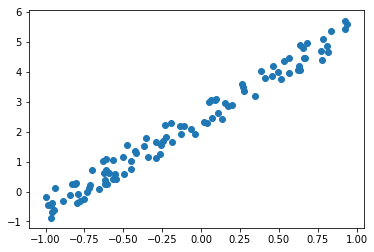

In [7]:
plt.scatter(x[:,0], y);

In [8]:
def mse(y_hat, y): return ((y_hat-y)**2).mean(0)

In [9]:
device = torch.device('cuda') if use_gpu and torch.cuda.is_available() else torch.device('cpu')
x = x.to(device)
y = y.to(device)

In [10]:
# initial weights
w0 = torch.rand(2) * 1000 - 500; w0

tensor([ 214.6787, -491.5229])

## "Stepper SGD" (vanilla SGD)

In [11]:
def train_stepper_sgd(w0, lr, n_epochs=100, min_loss=0.1, verbose=True):
    w = w0[:,None].clone().to(device).requires_grad_()
    if verbose: print('Epoch\tLoss')
    
    for i in range(n_epochs):
        y_hat = x@w
        loss = mse(y, y_hat)
        loss.backward()

        with torch.no_grad():
            w -=  lr * w.grad
            w.grad.zero_()
        if verbose: print(f'{i+1}\t{loss.item():.3f}')
        if loss.item() < min_loss: break
    print(f'Final loss: {loss.item():.3f} in {i+1} epochs.')

In [12]:
lr = 0.3
train_stepper_sgd(w0, lr)

Epoch	Loss
1	287112.469
2	44595.219
3	7959.141
4	2058.046
5	874.773
6	498.912
7	313.233
8	201.491
9	130.359
10	84.459
11	54.747
12	35.500
13	23.030
14	14.951
15	9.716
16	6.324
17	4.127
18	2.703
19	1.780
20	1.183
21	0.795
22	0.544
23	0.382
24	0.277
25	0.208
26	0.164
27	0.135
28	0.117
29	0.105
30	0.097
Final loss: 0.097 in 30 epochs.


## "Walker SGD"

In [14]:
def train_walker_sgd(w0, lrs, n_epochs=100, min_loss=0.1, verbose=True, record=False):
    lrs = torch.tensor(lrs, dtype=torch.float32).to(device)
    n_lrs = lrs.size(0)
    w = w0.repeat(n_lrs, 1).transpose(0,1).clone().to(device).requires_grad_()
    if record: rec = []
    
    if verbose: print('Epoch\tLR\tLoss')
    
    for i in range(n_epochs):
        w_rec = w.data
        y_hat = x@w
        losses = mse(y, y_hat)

        # identify the best learning rate
        bst_lr_idx = losses.argmin()
        bst_loss = losses[bst_lr_idx]    
        bst_loss.backward()

        with torch.no_grad():
            # take the weights of the best lr and copy them over the others lrs,
            # dismissing weights from non-optimal lrs.
            w_grad = w.grad[:,bst_lr_idx].repeat(n_lrs, 1).transpose(0,1)
            w.data = w.data[:,bst_lr_idx].repeat(n_lrs, 1).transpose(0,1)
            w.data -=  lrs * w_grad
            w.grad.zero_()
            
        if record: rec.append((w_rec.to('cpu'), losses.data.to('cpu'), bst_lr_idx.to('cpu')))
        if verbose: print(f'{i+1}\t{lrs[bst_lr_idx].item():.2f}\t{bst_loss.item():.3f}')
        if bst_loss.item() < min_loss: break

    print(f'Final loss: {bst_loss.item():.3f} in {i+1} epochs.')
    if record: 
        rec = list(zip(*rec))
        wgts = np.stack(rec[0])
        loss = np.stack(rec[1])
        best = np.stack(rec[2])
        return wgts, loss, best

In [15]:
lrs = np.arange(0.1, 1, 0.1)
train_walker_sgd(w0, lrs);

Epoch	LR	Loss
1	0.10	287112.469
2	0.50	2092.768
3	0.90	459.608
4	0.70	122.471
5	0.80	32.740
6	0.70	8.685
7	0.80	2.412
8	0.70	0.689
9	0.70	0.247
10	0.80	0.126
11	0.70	0.094
Final loss: 0.094 in 11 epochs.


## Visualizing "Walker SGD"

In [16]:
from mpl_toolkits import mplot3d
from matplotlib import animation
plt.rc('animation', html='html5')

In [17]:
def loss_wrt_wgts(w1, w2):
    w = torch.Tensor([w1, w2]).to(device)
    y_hat = x@w
    loss = mse(y_hat[:,None], y)
    return loss.item()
loss_wgts = np.vectorize(loss_wrt_wgts)

w0_range = np.linspace(-20, 20, 50)
w1_range = np.linspace(-20, 20, 50)
mesh = np.meshgrid(w0_range, w1_range)
loss_mesh = loss_wgts(*mesh)

In [18]:
w0 = torch.tensor([-19., -19])
lrs = np.linspace(0.1, 1, 7)
wgts, loss, best  = train_walker_sgd(w0, lrs, record=True)

Epoch	LR	Loss
1	0.10	507.883
2	0.55	94.030
3	1.00	16.269
4	0.70	4.323
5	0.70	1.234
6	0.85	0.380
7	0.70	0.160
8	0.70	0.103
9	0.85	0.088
Final loss: 0.088 in 9 epochs.


In [28]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')

ax.plot_surface(*mesh, loss_mesh, cmap='viridis', alpha=0.8)
line0, = ax.plot3D([], [], [], c='r', marker='o', label='Current walk') 
line1, = ax.plot3D([], [], [], c='b', marker='o', label='Learning curve')
line2, = ax.plot3D([], [], [], c='r', marker='*', markersize=20, label='Best step in walk', linewidth=0)

ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
fig.suptitle(f'"Walker SGD"', fontsize=22)
ax.view_init(30, 20)
ax.legend()
fig.tight_layout()
plt.close()

def animate(i):
    if i > 0:
        line0.set_data(wgts[i,0], wgts[i,1])
        line0.set_3d_properties(loss[i])
        line2.set_data(wgts[i,0,best[i]], wgts[i,1,best[i]])
        line2.set_3d_properties(loss[i,best[i]])
    
    rng = range(i)
    line1.set_data(wgts[rng,0,best[:i]], wgts[rng,1,best[:i]])
    line1.set_3d_properties(loss[rng,best[:i]])
    
    return line0, line1, line2

animation.FuncAnimation(fig, animate, 6, interval=1000)

## Benchmarking

In [21]:
n = 1000000
torch.manual_seed(17);

In [22]:
w0 = torch.rand(2) * 1000 - 500; w0

tensor([-65.7588,  35.1096])

### "Walker SGD"

In [23]:
lrs = np.linspace(0.1, 1, 10)
%time train_walker_sgd(w0, lrs, verbose=False)

Final loss: 0.096 in 9 epochs.
CPU times: user 21.2 ms, sys: 0 ns, total: 21.2 ms
Wall time: 5.2 ms


### "Stepper SGD" (vanilla SGD)

In [24]:
lr = 0.1
%time train_stepper_sgd(w0, lr, verbose=False)

Final loss: 0.098 in 85 epochs.
CPU times: user 99.7 ms, sys: 3.51 ms, total: 103 ms
Wall time: 25.6 ms


In [25]:
lr = 0.9
%time train_stepper_sgd(w0, lr, verbose=False)

Final loss: 0.100 in 36 epochs.
CPU times: user 13 ms, sys: 51 µs, total: 13.1 ms
Wall time: 12.2 ms


In [26]:
lr = 0.5
%time train_stepper_sgd(w0, lr, verbose=False)

Final loss: 0.092 in 16 epochs.
CPU times: user 2.09 ms, sys: 3.85 ms, total: 5.94 ms
Wall time: 5.35 ms


In [27]:
lr = 0.7 # optimal learning rate
%time train_stepper_sgd(w0, lr, verbose=False)

Final loss: 0.089 in 11 epochs.
CPU times: user 4.01 ms, sys: 0 ns, total: 4.01 ms
Wall time: 3.6 ms


## End!